# Intro

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import umap.umap_ as umap
pd.set_option('display.max_columns', 100)

2024-10-03 18:03:34.253548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading data

In [2]:
prod1 = pd.read_excel('/Users/karoljarzabek/Code_Projects/produkty_ksiazki_1_10.xlsx')
prod2 = pd.read_excel('/Users/karoljarzabek/Code_Projects/produkty_ksiazki_11_20.xlsx')
prod3 = pd.read_excel('/Users/karoljarzabek/Code_Projects/produkty_ksiazki_21_30.xlsx')
prod4 = pd.read_excel('/Users/karoljarzabek/Code_Projects/produkty_ksiazki_31_40.xlsx')
prod5 = pd.read_excel('/Users/karoljarzabek/Code_Projects/produkty_ksiazki_41_50.xlsx')
prod6 = pd.read_excel('/Users/karoljarzabek/Code_Projects/produkty_ksiazki_51_55.xlsx')
prod_list = [prod1, prod2, prod3, prod4, prod5, prod6]
source_df = pd.concat(prod_list)

In [3]:
source_df['Cena (zł)'] = pd.to_numeric(source_df['Cena (zł)'].str.replace(',', '.'), errors='coerce')
source_df['Rok wydania'] = pd.to_numeric(source_df['Rok wydania'], errors='coerce')
source_df.reset_index(inplace=True, drop=True)
source_df['czy_tlumaczone'] = np.where(source_df['Tłumacz'] == 'Brak', 0, 1)

### One-Hot Encoding

In [4]:
source_df['Tagi'] = source_df['Tagi'].str.split(',').apply(lambda x: sorted(x))
exp = source_df.explode('Tagi')
one_hot = pd.get_dummies(exp['Tagi'])
one_hot = one_hot.groupby(exp.index).sum()

In [5]:
df_tags = pd.concat([source_df, one_hot], axis=1)


### Including author's popularity

In [6]:
authors_pop_df = pd.read_excel('/Users/karoljarzabek/Code_Projects/authors_df.xlsx')
pop_df = authors_pop_df.drop('Page', axis=1)
pop_df.rename(columns={'Author' : 'Autor'}, inplace=True)
df_tag_pop = pd.merge(df_tags, pop_df, on='Autor', how='left')
df_tag_pop['Popularity'] = df_tag_pop['Popularity'].fillna(0)


In [7]:
n = 2000
pop_df.iloc[n:n+20]

,Autor,Popularity
2000,Muszyński Andrzej,7999
2001,Rient Robert,7998
2002,Markowski Andrzej,7997
2003,Piątek Grzegorz,7996
2004,Żarski Przemysław,7995
2005,Leighton M.,7994
2006,Spoto Donald,7993
2007,Reeve Philip,7992
2008,King Owen,7991
2009,McMann Lisa,7990


# Analysis

### `Preparing data` | output: clean_df

In [8]:
clean_df = df_tag_pop.dropna()
X = clean_df.drop(['Tytuł', 'Autor', 'Cena (zł)', 'Tłumacz', 'Wydawca', 'Tagi', ''], axis=1)
y = clean_df['Cena (zł)']

In [9]:
X_y = X.copy()
X_y['Cena'] = y

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
clean_df.sample(5)

,Tytuł,Autor,Cena (zł),Wydawca,Tłumacz,Rok wydania,Tagi,czy_tlumaczone,,1939-1945,Architektura,Autografy,Bibliofilia i bibliologia,Biografie,Czasopisma,Dzieje najnowsze,Ekonomia,Etnografia,Film,Filozofia,Fotografika,Geografia i turystyka,Gospodarstwo domowe,Historia,Hobby,Komiks i książka graficzna,Książki,Książki dla dzieci,Malarstwo,Militaria,Muzyka,Nauki humanistyczne,Nauki przyrodnicze i ścisłe,Numizmatyka,O literaturze,Pedagogika,Pierwsze wydania,Pocztówki,Poezja,Poezja polska,Poezja zagraniczna,Politologia,Prawo,Proza,Proza polska,Proza zagraniczna,Psychologia,Religie i wierzenia,Satyra-humor,Socjologia,Starożytność,Syntezy dziejów,Sztuka,Sztuka użytkowa,Słowniki i encyklopedie,Teatr,Teoria i historia sztuki,Varsaviana,XIX-1914,XVI-XVIII,grafika,listy,poradniki,rzeźba,wspomnienia,Łowiectwo,Średniowiecze,1914-1939,1939-1945,Antologie,Archeologia,Architektura,Autografy,Bibliofilia i bibliologia,Biografie,Czasopisma,Dzieje najnowsze,Ekonomia,Etnografia,Film,Filozofia,Fotografie,Fotografika,Geografia i turystyka,Gospodarstwo domowe,Grafika,Historia,Hobby,Komiks i książka graficzna,Książki,Popularity
205,ENGLISH PERIOD FURNITURE. AN ACCOUNT OF THE EV...,Brak,120.0,Evans Brothers Limited,Brak,1963.0,"[ Sztuka, Sztuka użytkowa, Książki]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0
519,ROCZNIK LITERACKI ZA ROK 1936,Brak,75.0,Instytut Literacki -Warszawa,Brak,1937.0,"[ Książki, Nauki humanistyczne, O literaturz...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
978,ROMANS POLSKI WIEKU XVI,Krzyżanowski Julian,48.0,Towarzystwo Przyjaciół Nauk w Lublinie,Brak,1934.0,"[ Książki, Nauki humanistyczne, O literaturz...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
653,UPADEK KONSTANTYNOPOLA 1453,Runciman Steven,65.0,PIW,Dębnicki Antoni,1994.0,"[ Książki, Średniowiecze, Historia]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6622.0
2109,CIĄGLE PO KOLE. ROZMOWA Z ŻOŁNIERZAMI GETTA WA...,Grupińska Anka,20.0,Wydawnictwo Czarne,Brak,2013.0,"[ Historia, Książki, 1939-1945]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


## Models

### `PCA`

#### Setup

In [12]:
pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 2))], verbose=True)
pca_pipe.fit(X_y)
X_pca = pca_pipe.transform(X_y)


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing pca, total=   0.0s


In [24]:
pca1 = X_pca[10:,0]
pca2 = X_pca[10:,1]
price = y[10:]
art = X[' Sztuka'][10:]

In [14]:
X_y.columns

Index(['Rok wydania', 'czy_tlumaczone', ' 1939-1945', ' Architektura',
       ' Autografy', ' Bibliofilia i bibliologia', ' Biografie', ' Czasopisma',
       ' Dzieje najnowsze', ' Ekonomia', ' Etnografia', ' Film', ' Filozofia',
       ' Fotografika', ' Geografia i turystyka', ' Gospodarstwo domowe',
       ' Historia', ' Hobby', ' Komiks i książka graficzna', ' Książki',
       ' Książki dla dzieci', ' Malarstwo', ' Militaria', ' Muzyka',
       ' Nauki humanistyczne', ' Nauki przyrodnicze i ścisłe', ' Numizmatyka',
       ' O literaturze', ' Pedagogika', ' Pierwsze wydania', ' Pocztówki',
       ' Poezja', ' Poezja polska', ' Poezja zagraniczna', ' Politologia',
       ' Prawo', ' Proza', ' Proza polska', ' Proza zagraniczna',
       ' Psychologia', ' Religie i wierzenia', ' Satyra-humor', ' Socjologia',
       ' Starożytność', ' Syntezy dziejów', ' Sztuka', ' Sztuka użytkowa',
       ' Słowniki i encyklopedie', ' Teatr', ' Teoria i historia sztuki',
       ' Varsaviana', ' XIX-1914

#### Explaination

In [15]:
explained_variance_ratio = pca_pipe.named_steps['pca'].explained_variance_ratio_
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {ratio*100:.2f}% of variance")

Principal Component 1: 5.83% of variance
Principal Component 2: 5.49% of variance


In [16]:
explained_variance_ratio[0]

0.058293046704860886

In [17]:
pca = pca_pipe.named_steps['pca']
components = pca_pipe.named_steps['pca'].components_
feature_names = X_y.columns  # Or a list of column names in case of a DataFrame

In [18]:
pca_loadings = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=feature_names)

In [19]:
pca_loadings

,PC1,PC2
Rok wydania,0.010397,-0.054880
czy_tlumaczone,-0.163723,-0.063826
1939-1945,0.117150,-0.110477
Architektura,0.033230,-0.016789
Autografy,0.010752,-0.007286
...,...,...
Hobby,0.014417,0.019137
Komiks i książka graficzna,0.008078,-0.001724
Książki,-0.349854,0.114213
Popularity,-0.226098,-0.054405


In [20]:
pca_loadings.sort_values('PC1', ascending=False).head(5)

,PC1,PC2
Książki,0.349333,-0.112259
Historia,0.228544,-0.189829
wspomnienia,0.221040,-0.177543
listy,0.221040,-0.177543
Sztuka,0.170135,0.339293


In [21]:
pca_loadings.sort_values('PC2', ascending=False).head(5)

,PC1,PC2
Malarstwo,0.146672,0.389556
grafika,0.146672,0.389556
rzeźba,0.146672,0.389556
Sztuka,0.170135,0.339293
Teoria i historia sztuki,0.132620,0.302559


#### Plot

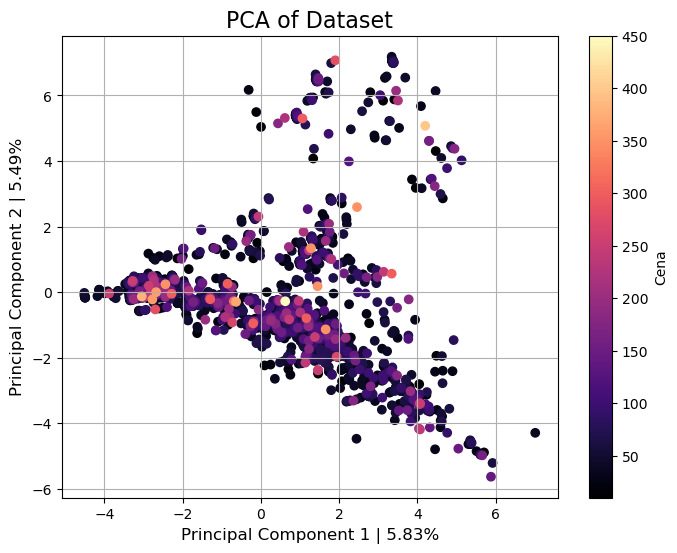

In [74]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x=pca1[::-1], 
                      y=pca2[::-1], 
                      c=price[::-1], 
                      cmap='magma')
plt.title('PCA of Dataset', fontsize=16)
plt.xlabel(f'Principal Component 1 | {explained_variance_ratio[0]*100:.2f}%', fontsize=12)
plt.ylabel(f'Principal Component 2 | {explained_variance_ratio[1]*100:.2f}%', fontsize=12)
plt.colorbar(scatter, label='Cena')
plt.grid(True)
plt.show()

### `Gradient Boost`

#### Engine

In [86]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Standardize the features
    ('gbr', GradientBoostingRegressor())  # Step 2: Apply Gradient Boosting Regression
])

In [99]:
param_grid = {
    'gbr__n_estimators': [200, 300, 400, 500, 600],
    'gbr__learning_rate': [0.005, 0.01, 0.02, 0.05],
    'gbr__max_depth': [2, 3, 4]
}

In [100]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated MSE: {-grid_search.best_score_}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'gbr__learning_rate': 0.02, 'gbr__max_depth': 2, 'gbr__n_estimators': 600}
Best cross-validated MSE: 3986.304440730907


In [104]:
gbr_y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, gbr_y_pred)
print(f"Mean Squared Error on test data: {mse}")

Mean Squared Error on test data: 2402.655088297818


#### Graph

In [105]:
gbr_y_pred_global = grid_search.best_estimator_.predict(X)

In [111]:
clean_df.shape

(2398, 91)

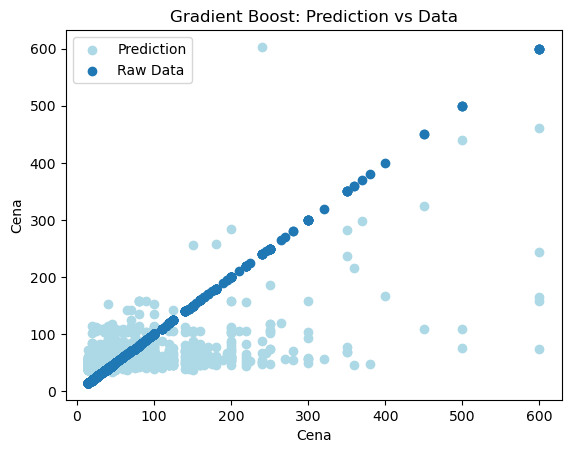

In [139]:
m = 1
n = 2300
a = clean_df['Cena (zł)'].iloc[m:n]
b = gbr_y_pred_global[m:n]
c = clean_df['Cena (zł)'].iloc[m:n]

plt.scatter(x=a, y=b, color = 'lightblue', label = 'Prediction')
plt.scatter(x=a, y=c, label = 'Raw Data')
plt.title('Gradient Boost: Prediction vs Data')
plt.xlabel('Cena')
plt.ylabel('Cena')
plt.legend()
plt.show()

### `K Means Clustering`

#### Engine

In [161]:
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Step 1: Normalize the data
    ('kmeans', KMeans(n_clusters=8))   # Step 2: Apply K-Means (choose the number of clusters)
])
kmeans_pipeline.fit(X_y)

Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans())])

#### Graph

In [171]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2398 entries, 0 to 2455
Data columns (total 84 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rok wydania                   2398 non-null   float64
 1   czy_tlumaczone                2398 non-null   int64  
 2    1939-1945                    2398 non-null   int64  
 3    Architektura                 2398 non-null   int64  
 4    Autografy                    2398 non-null   int64  
 5    Bibliofilia i bibliologia    2398 non-null   int64  
 6    Biografie                    2398 non-null   int64  
 7    Czasopisma                   2398 non-null   int64  
 8    Dzieje najnowsze             2398 non-null   int64  
 9    Ekonomia                     2398 non-null   int64  
 10   Etnografia                   2398 non-null   int64  
 11   Film                         2398 non-null   int64  
 12   Filozofia                    2398 non-null   int64  
 13   Fotogra

In [162]:
labels = kmeans_pipeline['kmeans'].labels_
sil_score = silhouette_score(X, labels)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: -0.6513647746473541


In [163]:
# Normalize the data
scaler = StandardScaler()
k_means_X_scaled = scaler.fit_transform(X_y)

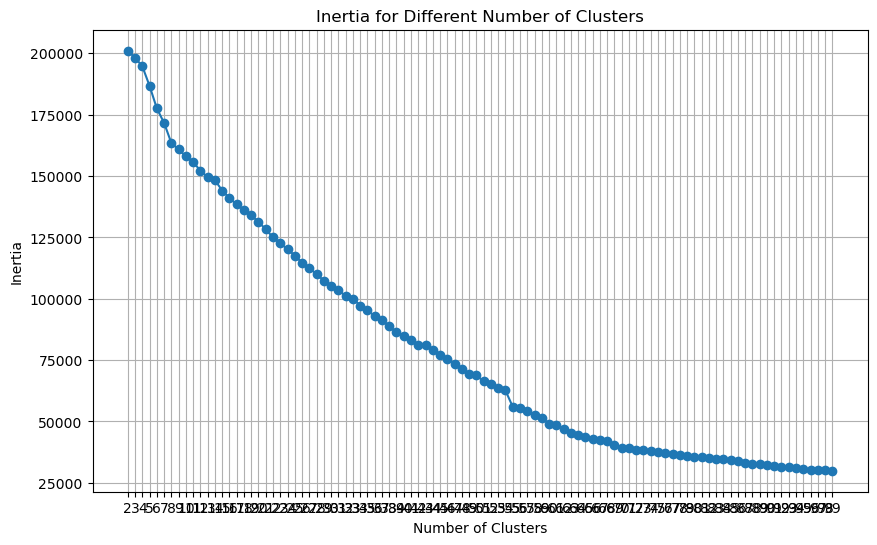

In [168]:
# List of cluster counts to evaluate
cluster_counts = range(2, 100)
inertia_values = []

# Calculate inertia for each cluster count
for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(k_means_X_scaled)
    inertia_values.append(kmeans.inertia_)

# Plotting the inertia values
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia for Different Number of Clusters')
plt.xticks(cluster_counts)  # Set x-ticks to be the cluster counts
plt.grid()
plt.show()

### `UMAP`

In [178]:
# Initialize UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
# If you want to integrate it into a scikit-learn pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # You might want to scale your data first
    ('umap', umap_model)
])
# Fit and transform the data
X_umap = pipeline.fit_transform(X)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


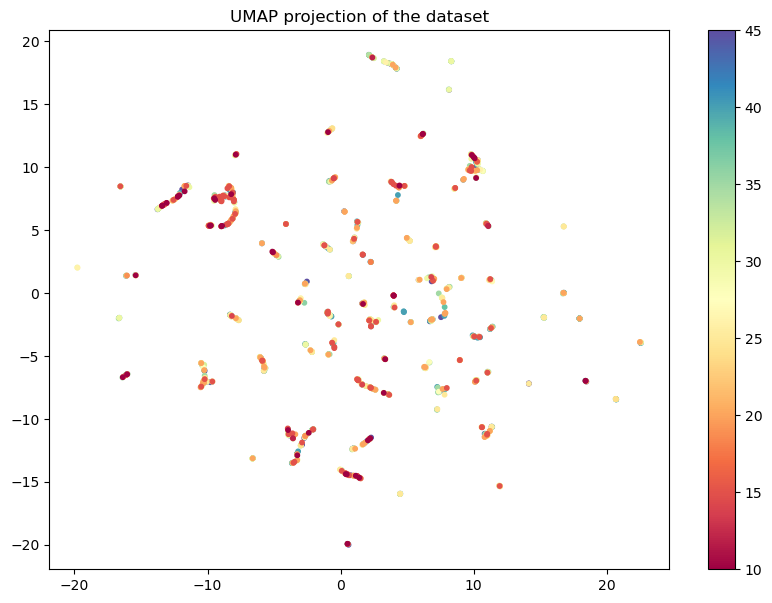

In [183]:
# Plotting UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(X_umap[1000:, 0], X_umap[1000:, 1], c=y[1000:], cmap='Spectral', s=10)
plt.colorbar()
plt.title('UMAP projection of the dataset')
plt.show()